In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, InputLayer
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras import applications

from keras.optimizers import Adam, SGD, RMSprop

In [ ]:
image_size_sq = 96
no_channels = 3

## Loading training datasets

In [ ]:
# Path for data from Google Drive

DATA_PATH = '/content/drive/My Drive/projects/Syn_Classification'

# Creating numpy binary file to store preprocessed images for quicker loading
FF_data_bin = os.path.join(DATA_PATH,
        f'FF_data.npy')


print(f"Looking for file: {FF_data_bin}")

if not os.path.isfile(FF_data_bin):
  start = time.time()
  print("Loading FF images...")

  FF_training_data = []
  FF_path = os.path.join(DATA_PATH,'Generator_crawl')
  for filename in tqdm(os.listdir(FF_path)):
      path = os.path.join(FF_path,filename)
      image = Image.open(path).resize((image_size_sq,
            image_size_sq),Image.ANTIALIAS)
      FF_training_data.append(np.asarray(image))

  x = FF_training_data[1:]
  y=[]
  print(len(x))
  #t = np.reshape(x, (-1,96,96,3))
  for i in x:
    #print(i.shape)
    if i.shape != (96,96,3):
      print(False)
    else:
      y.append(i)

  print(len(y))

  
  FF_training_data = np.reshape(y,(-1,image_size_sq,
            image_size_sq,no_channels))
  FF_training_data = FF_training_data.astype(np.float32)
  #FF_training_data = FF_training_data / 127.5 - 1.

  print("Saving training image binary...")
  np.save(FF_data_bin,FF_training_data)
  elapsed = time.time()-start
  print("Saved FF")

else:
  FF_training_data = np.load(FF_data_bin)
  print("Loaded previously saved...")

# No fire data
DATA_PATH = '/content/drive/My Drive/projects/Gen_Classification'
NoF_data_bin = os.path.join(DATA_PATH,
        f'NoF_data.npy')

if not os.path.isfile(NoF_data_bin):
  start = time.time()
  print("Loading NoF images...")

  NoFF_training_data = []
  FF_path = os.path.join(DATA_PATH,'NoFire')
  for filename in tqdm(os.listdir(FF_path)):
      path = os.path.join(FF_path,filename)
      image = Image.open(path).resize((image_size_sq,
            image_size_sq),Image.ANTIALIAS)
      NoFF_training_data.append(np.asarray(image))
  
  
  x = NoFF_training_data[1:]
  y=[]
  print(len(x))
  #t = np.reshape(x, (-1,96,96,3))
  for i in x:
    #print(i.shape)
    if i.shape != (96,96,3):
      print(False)
    else:
      y.append(i)

  print(len(y))
  
  
  NoFF_training_data = np.reshape(y,(-1,image_size_sq,
            image_size_sq,no_channels))
  NoFF_training_data = NoFF_training_data.astype(np.float32)
  #NoFF_training_data = NoFF_training_data / 127.5 - 1.

  print("Saving training image binary...")
  np.save(NoF_data_bin,NoFF_training_data)
  print("Saved")
  elapsed = time.time()-start

else:
  NoFF_training_data = np.load(NoF_data_bin)
  print("Loaded previously saved...")


Looking for file: /content/drive/My Drive/projects/Syn_Classification/FF_data.npy
Loaded previously saved...
Loaded previously saved...


## Data prep

In [ ]:
#Checking size of both classes
FF_size = FF_training_data.shape
print("Size of FF data:", FF_size[0])

NoF_size = NoFF_training_data.shape
print("Size of NoFF data:", NoF_size[0])



Size of FF data: 1200
Size of NoFF data: 880


In [ ]:
FF_size_Label = np.ones((FF_size[0], 1), dtype=int)
NoF_size_Label = np.zeros((NoF_size[0], 1), dtype=int)
print( FF_size_Label.shape[0], NoF_size_Label.shape[0])

1200 880


In [ ]:
from sklearn.model_selection import train_test_split
#fire label 1
train_data1, val_data1, train_label1, val_label1 = train_test_split(FF_training_data, FF_size_Label, test_size = 0.2, random_state=4, shuffle= True )
#Nofire label 2
train_data2, val_data2, train_label2, val_label2 = train_test_split(NoFF_training_data, NoF_size_Label, test_size = 0.2, random_state=4, shuffle= True )

In [ ]:
print(train_data1.shape, train_data2.shape)
print(val_data1.shape, val_data2.shape)

(960, 96, 96, 3) (704, 96, 96, 3)
(240, 96, 96, 3) (176, 96, 96, 3)


In [ ]:
train_data = np.concatenate((train_data1, train_data2), axis =0)
train_label = np.concatenate((train_label1, train_label2), axis=0)

val_data = np.concatenate((val_data1, val_data2), axis =0)
val_label = np.concatenate((val_label1, val_label2), axis=0)

In [ ]:

#checking labeling
print(val_label1[0], val_label[0])
print(val_label2[0], val_label[239])
print(val_label.shape)

[1] [1]
[0] [1]
(416, 1)


In [ ]:
# Training data and Validation data Size
train_data_length = train_data.shape[0]
val_data_length = val_data.shape[0] 
print(train_data.shape, train_data_length)
print(val_data.shape, val_data_length)

(1664, 96, 96, 3) 1664
(416, 96, 96, 3) 416


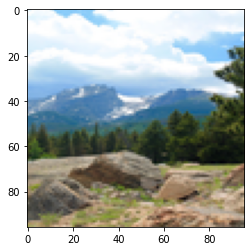

In [ ]:
i = 158
x = np.reshape(train_data[995], (96,96,3))
img = x 
img = img.astype(np.uint8)
im = Image.fromarray(img)
plt.imshow(img)

In [ ]:
train_datagen = ImageDataGenerator(
              rotation_range=10,
              width_shift_range=0.2,
              height_shift_range=0.2,
              rescale=1./255,
              #shear_range=0.2,
              zoom_range=0.2,
              horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
BS = 32
Ep = 100
train_gen = train_datagen.flow(x = train_data, y=train_label, batch_size=BS)
validation_gen = test_datagen.flow(x = val_data, y= val_label, batch_size=BS)



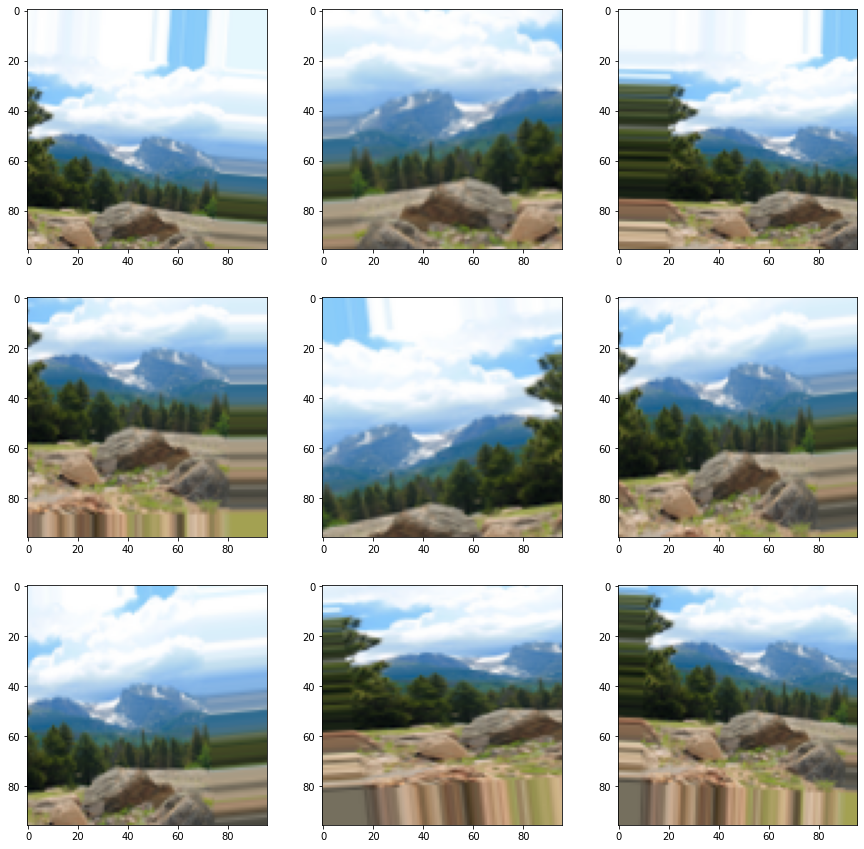

In [ ]:
# ImageDataGenerator rotation
#datagen = ImageDataGenerator(rotation_range=30, fill_mode='nearest')
from matplotlib import pyplot
x = np.reshape(train_data[995], (1, 96,96, 3))
# iterator
aug_iter = train_datagen.flow(x, batch_size=1)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# generate batch of images
for i in range(0, 9):

	# convert to unsigned integers
	#image = next(aug_iter)[0].astype('uint8') * 255
  pyplot.subplot(330 + 1 + i)
  #print(aug_iter[i].min(), aug_iter[i].max())
  pyplot.imshow(next(aug_iter).reshape(96,96,3))
	# plot image
	#ax[i].imshow(image)
	#ax[i].axis('off')

## Basic CNN

In [ ]:
from keras.losses import binary_crossentropy
from keras.optimizers import Adam, SGD, RMSprop

def create_model():

  loss_func = binary_crossentropy
  #opt = RMSprop
  model = Sequential()

  model.add(Conv2D(32, (3, 3), input_shape=(96,96,3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(64))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  model.compile(optimizer='rmsprop', loss= loss_func, metrics=['accuracy'])
  return model

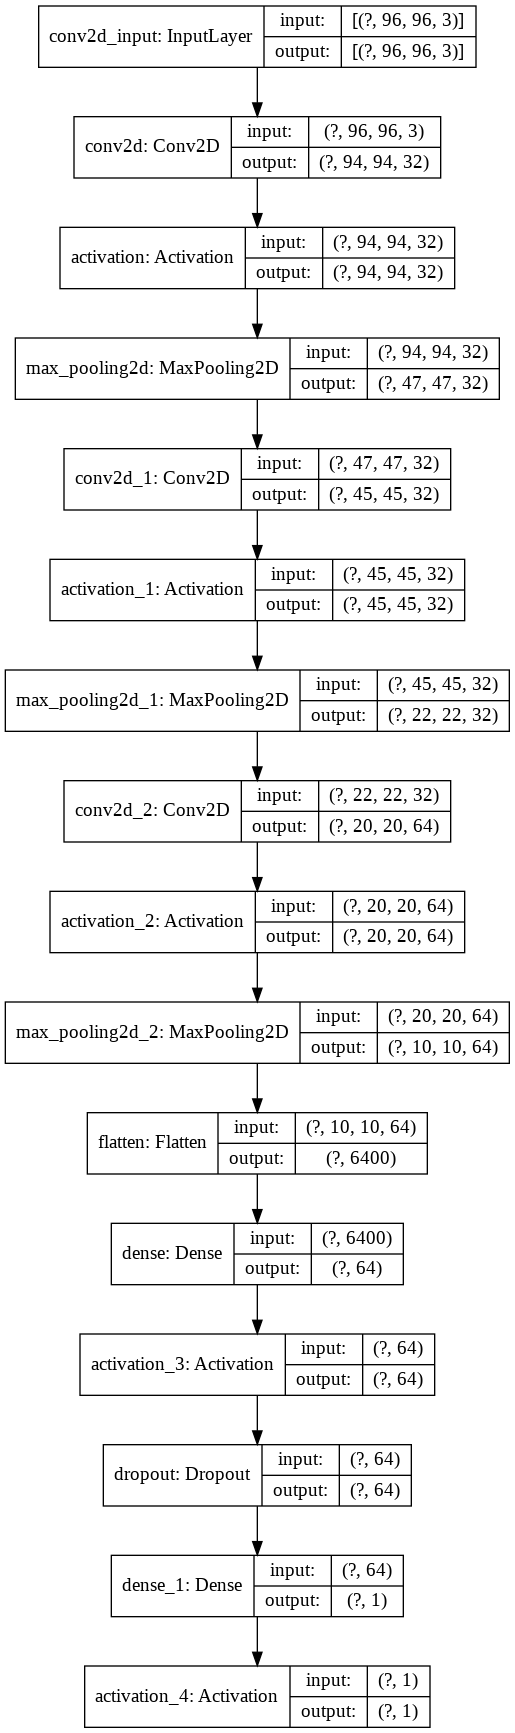

In [ ]:
classifier = create_model()
plot_model(classifier, show_shapes=True, to_file='Classifier.png')

In [ ]:
checkpoint_filepath = 'classifier/checkpoint'
checkpt = ModelCheckpoint(
                  filepath=checkpoint_filepath,
                  save_weights_only=True,
                  monitor='val_accuracy',
                  mode='max',
                  save_best_only=True)

In [ ]:
hist = classifier.fit_generator(train_gen, steps_per_epoch= train_data_length // BS, 
                    epochs= Ep, verbose=1, validation_data=validation_gen,
                    validation_steps= val_data_length // BS )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
52/52 [==============================] - 24s 470ms/step - loss: 0.6108 - accuracy: 0.6869 - val_loss: 0.3291 - val_accuracy: 0.8870
Epoch 2/100
52/52 [==============================] - 20s 388ms/step - loss: 0.3490 - accuracy: 0.8546 - val_loss: 0.2443 - val_accuracy: 0.9062
Epoch 3/100
52/52 [==============================] - 20s 386ms/step - loss: 0.3277 - accuracy: 0.8588 - val_loss: 0.4809 - val_accuracy: 0.8101
Epoch 4/100
52/52 [==============================] - 20s 384ms/step - loss: 0.2790 - accuracy: 0.8840 - val_loss: 0.4113 - val_accuracy: 0.8269
Epoch 5/100
52/52 [==============================] - 20s 384ms/step - loss: 0.2612 - accuracy: 0.8924 - val_loss: 0.2164 - val_accuracy: 0.9038
Epoch 6/100
52/52 [==============================] - 20s 385ms/step - loss: 0.2270 - accuracy: 0.9008 - val_loss: 0.6153 - val_accuracy: 0.7909
Epoch 7/100
52/52 [==============================] - 20s 385

In [ ]:
classifier.save_weights("RF-SF_BasicCNN.h5")

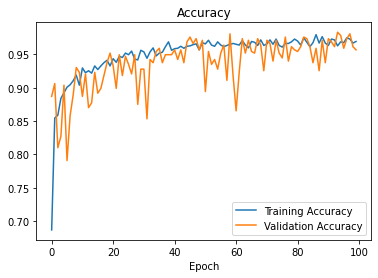

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
#plt.plot(hist.history['loss'])
plt.title("Accuracy")
#plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training Accuracy","Validation Accuracy","loss"])
plt.show()

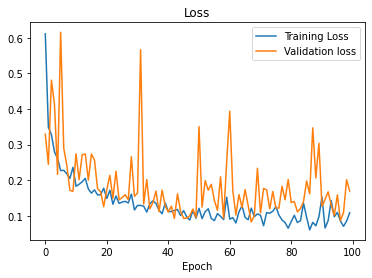

In [ ]:

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Loss")
#plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training Loss","Validation loss"])
plt.show()

# VGG

In [ ]:
from keras.losses import binary_crossentropy
from keras.optimizers import Adam, SGD

In [ ]:
# build the VGG16 network
model = applications.VGG16(include_top=False, weights='imagenet', input_shape=(96,96,3))
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
______________________________________________________________

In [ ]:
feature_ext_path = os.path.join(DATA_PATH,
                    f'feature_ext.npy')
feature_ext_val_path = os.path.join(DATA_PATH,
                    f'feature_ext_val.npy')
train_datagen = ImageDataGenerator(rescale=1./255)

generator = train_datagen.flow(x = train_data, y=train_label, batch_size=BS, shuffle=False)
feature_ext = model.predict_generator(generator, train_data_length // BS )
np.save(feature_ext_path, feature_ext)
print("Saved training features")

val_gen = train_datagen.flow(x = val_data, y=val_label, batch_size=BS, shuffle=False)
feature_ext = model.predict_generator(val_gen, val_data_length // BS )
np.save(feature_ext_val_path, feature_ext)
print("Saved validation features")

Instructions for updating:
Please use Model.predict, which supports generators.
Saved training features
Saved validation features


## 2. Training with pretrained vgg16

In [ ]:
train_data_extracted = np.load(feature_ext_path)
val_data_extracted =  np.load(feature_ext_val_path)

print(train_data_extracted.shape, val_data_extracted.shape)

(1664, 3, 3, 512) (416, 3, 3, 512)


In [ ]:
print(train_label1.shape, train_label2.shape, train_label.shape)

(960, 1) (704, 1) (1664, 1)


In [ ]:
train_data_extracted.shape[1:]


(3, 3, 512)

In [ ]:
from keras.optimizers import Adam, SGD, RMSprop
opt = RMSprop(learning_rate=0.0010)

model1 = Sequential()
model1.add(Flatten(input_shape= train_data_extracted.shape[1:]))
#model1.output_shape
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer=opt,
                  loss='binary_crossentropy', metrics=['accuracy'])

#plot_model(model1, show_shapes=True)

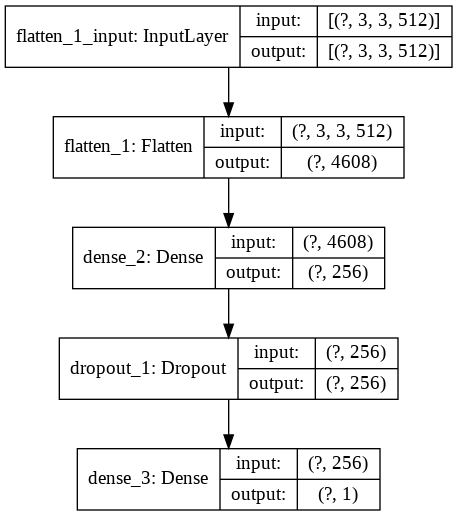

In [ ]:
plot_model(model1, show_shapes=True)
#model1.output_shape

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_filepath = 'classifier/checkpoint'
checkpt = ModelCheckpoint(
                  filepath=checkpoint_filepath,
                  save_weights_only=True,
                  monitor='val_accuracy',
                  mode='max',
                  save_best_only=True)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                      patience=75, verbose=1, mode='auto')

In [ ]:
epochs = 200
batch_size = 32
hist = model1.fit(train_data_extracted, train_label,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(val_data_extracted, val_label),
           callbacks=[checkpt,early])

Epoch 1/200
52/52 [==============================] - 1s 15ms/step - loss: 0.3402 - accuracy: 0.8960 - val_loss: 0.2196 - val_accuracy: 0.9183
Epoch 2/200
52/52 [==============================] - 1s 13ms/step - loss: 0.1038 - accuracy: 0.9603 - val_loss: 0.1129 - val_accuracy: 0.9471
Epoch 3/200
52/52 [==============================] - 1s 14ms/step - loss: 0.0765 - accuracy: 0.9663 - val_loss: 0.0565 - val_accuracy: 0.9760
Epoch 4/200
52/52 [==============================] - 1s 13ms/step - loss: 0.0442 - accuracy: 0.9808 - val_loss: 0.0952 - val_accuracy: 0.9663
Epoch 5/200
52/52 [==============================] - 1s 13ms/step - loss: 0.0346 - accuracy: 0.9862 - val_loss: 0.0802 - val_accuracy: 0.9808
Epoch 6/200
52/52 [==============================] - 1s 14ms/step - loss: 0.0238 - accuracy: 0.9910 - val_loss: 0.0753 - val_accuracy: 0.9856
Epoch 7/200
52/52 [==============================] - 1s 13ms/step - loss: 0.0127 - accuracy: 0.9952 - val_loss: 0.0661 - val_accuracy: 0.9856
Epoch 

In [ ]:
model1.save_weights("RF-SF_PreTrainedVGG.h5")

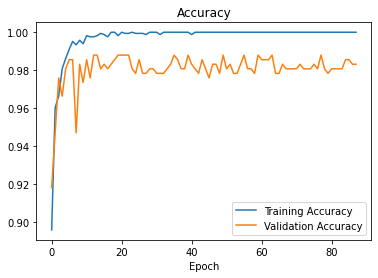

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
#plt.plot(hist.history['loss'])
plt.title("Accuracy")
#plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training Accuracy","Validation Accuracy","loss"])
plt.show()

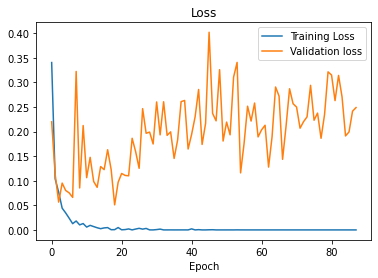

In [ ]:

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Loss")
#plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training Loss","Validation loss"])
plt.show()

## TEST

### Displaying images from FIRE and its classification

In [ ]:
image_size_sq = 96
testdata_fire = []
DATA_PATH = '/content/drive/My Drive/projects/Gen_Classification/test'
test_path = os.path.join(DATA_PATH,'fire')
for filename in tqdm(os.listdir(test_path)):
    path = os.path.join(test_path,filename)
    image = Image.open(path).resize((image_size_sq,
          image_size_sq),Image.ANTIALIAS)
    testdata_fire.append(np.asarray(image))

x = testdata_fire[1:]
y=[]
print(len(x))
#t = np.reshape(x, (-1,96,96,3))
for i in x:
  #print(i.shape)
  if i.shape != (96,96,3):
    print("False")
  else:
    y.append(i)

print(len(y))


testdata_fire = np.reshape(y,(-1,image_size_sq,
          image_size_sq,no_channels))
testdata_fire = testdata_fire.astype(np.float32)
#FF_training_data = FF_training_data / 127.5 - 1.

100%|██████████| 19/19 [00:03<00:00,  4.77it/s]

18
18


In [ ]:
test_data_length = testdata_fire.shape[0]
test_data_length

18

In [ ]:
# TO obtain extracted features of VGG16
BS = 1
test_data_length = testdata_fire.shape[0]
test_gen = train_datagen.flow(x = testdata_fire, batch_size=BS, shuffle=False)
feature_ext = model.predict_generator(test_gen, test_data_length // BS )
feature_ext[1].shape

(3, 3, 512)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


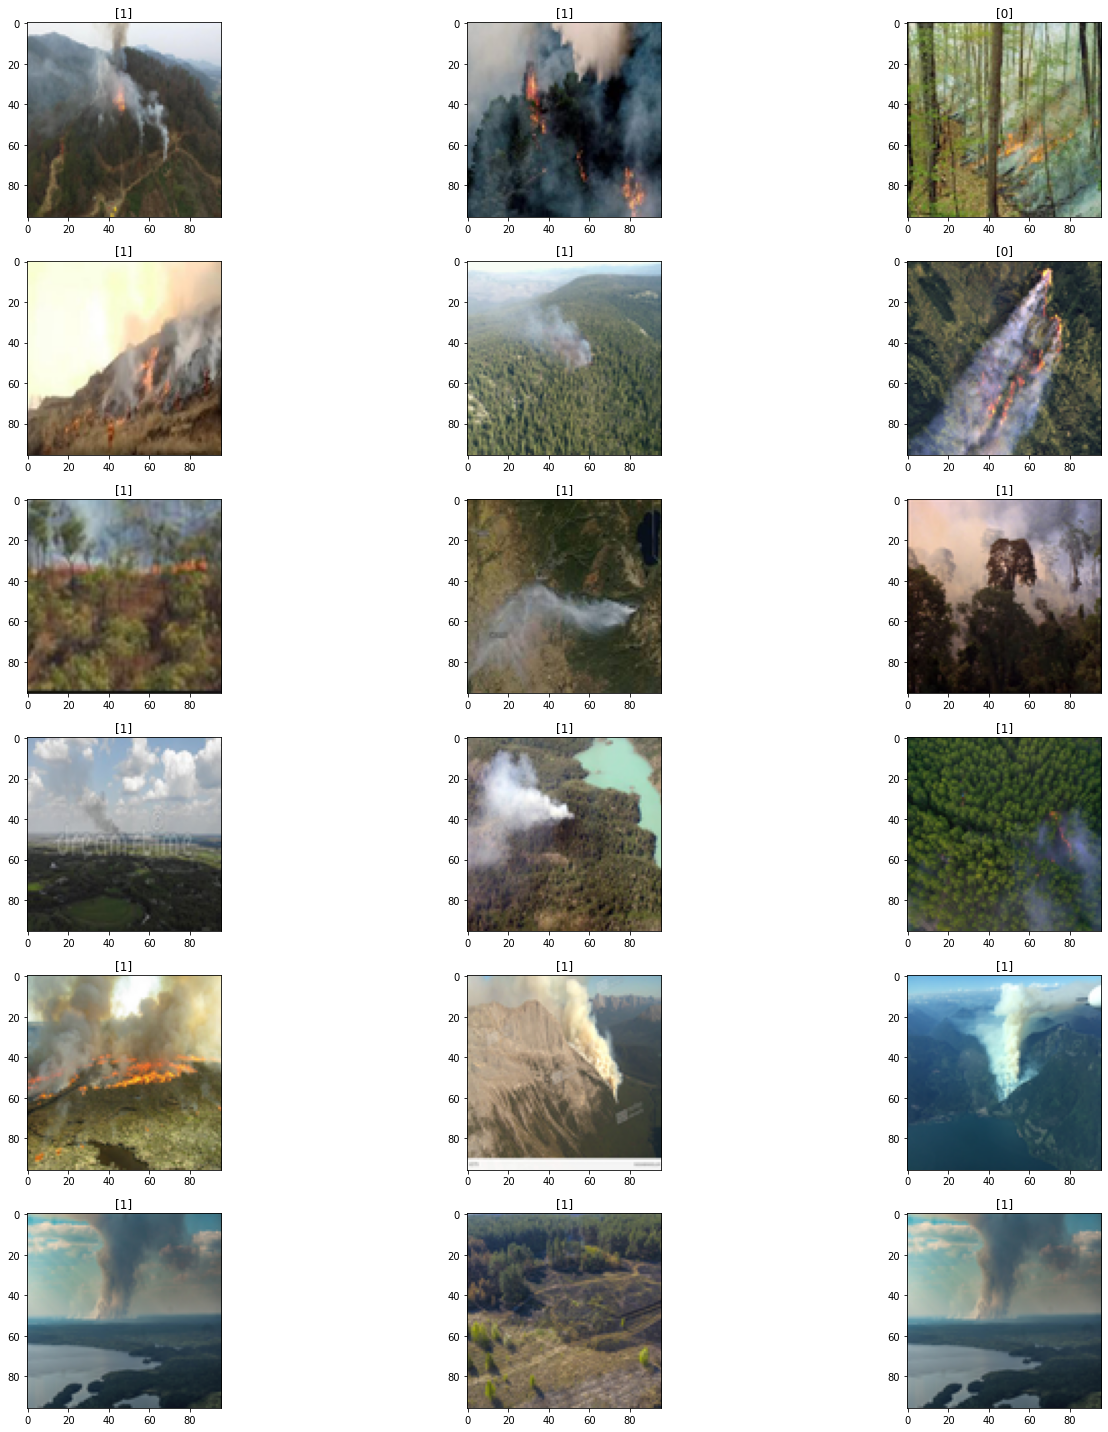

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(20,20))
l =  testdata_fire.shape[0]

#plt.figure(0)
count = 0;
for i in range(6):
    for j in range(3):
        plt.subplot2grid((6,3), (i,j))
        #ax[i,j].set_title('subplot 1')
        ax = plt.subplot2grid((6,3), (i,j))
        x = np.reshape(testdata_fire[count], (96,96,3))

        y = np.reshape(feature_ext[count], (1, 3,3,512))
        p = model1.predict_classes(y)
        

        #pred = model1.predict_classes(feature_ext[count])
        ax.set_title(p[0])
        #print("Class : ",pred)


        count = count + 1 
        img = x.astype(np.uint8)
        fig.tight_layout()
        pyplot.imshow(img)
plt.show()

###  Displaying images from No FIRE and its classification

In [ ]:
image_size_sq = 96
testdata_fire = []
DATA_PATH = '/content/drive/My Drive/projects/Gen_Classification/test'
test_path = os.path.join(DATA_PATH,'nofire')
for filename in tqdm(os.listdir(test_path)):
    path = os.path.join(test_path,filename)
    image = Image.open(path).resize((image_size_sq,
          image_size_sq),Image.ANTIALIAS)
    testdata_fire.append(np.asarray(image))

x = testdata_fire[1:]
y=[]
print(len(x))
#t = np.reshape(x, (-1,96,96,3))
for i in x:
  #print(i.shape)
  if i.shape != (96,96,3):
    print(False)
  else:
    y.append(i)

print(len(y))


testdata_fire = np.reshape(y,(-1,image_size_sq,
          image_size_sq,no_channels))
testdata_fire = testdata_fire.astype(np.float32)
#FF_training_data = FF_training_data / 127.5 - 1.

100%|██████████| 19/19 [00:04<00:00,  4.29it/s]

18
18


In [ ]:
BS = 1
test_data_length = testdata_fire.shape[0]
test_gen = train_datagen.flow(x = testdata_fire, batch_size=BS, shuffle=False)
feature_ext = model.predict_generator(test_gen, test_data_length // BS )
feature_ext.shape

(18, 3, 3, 512)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


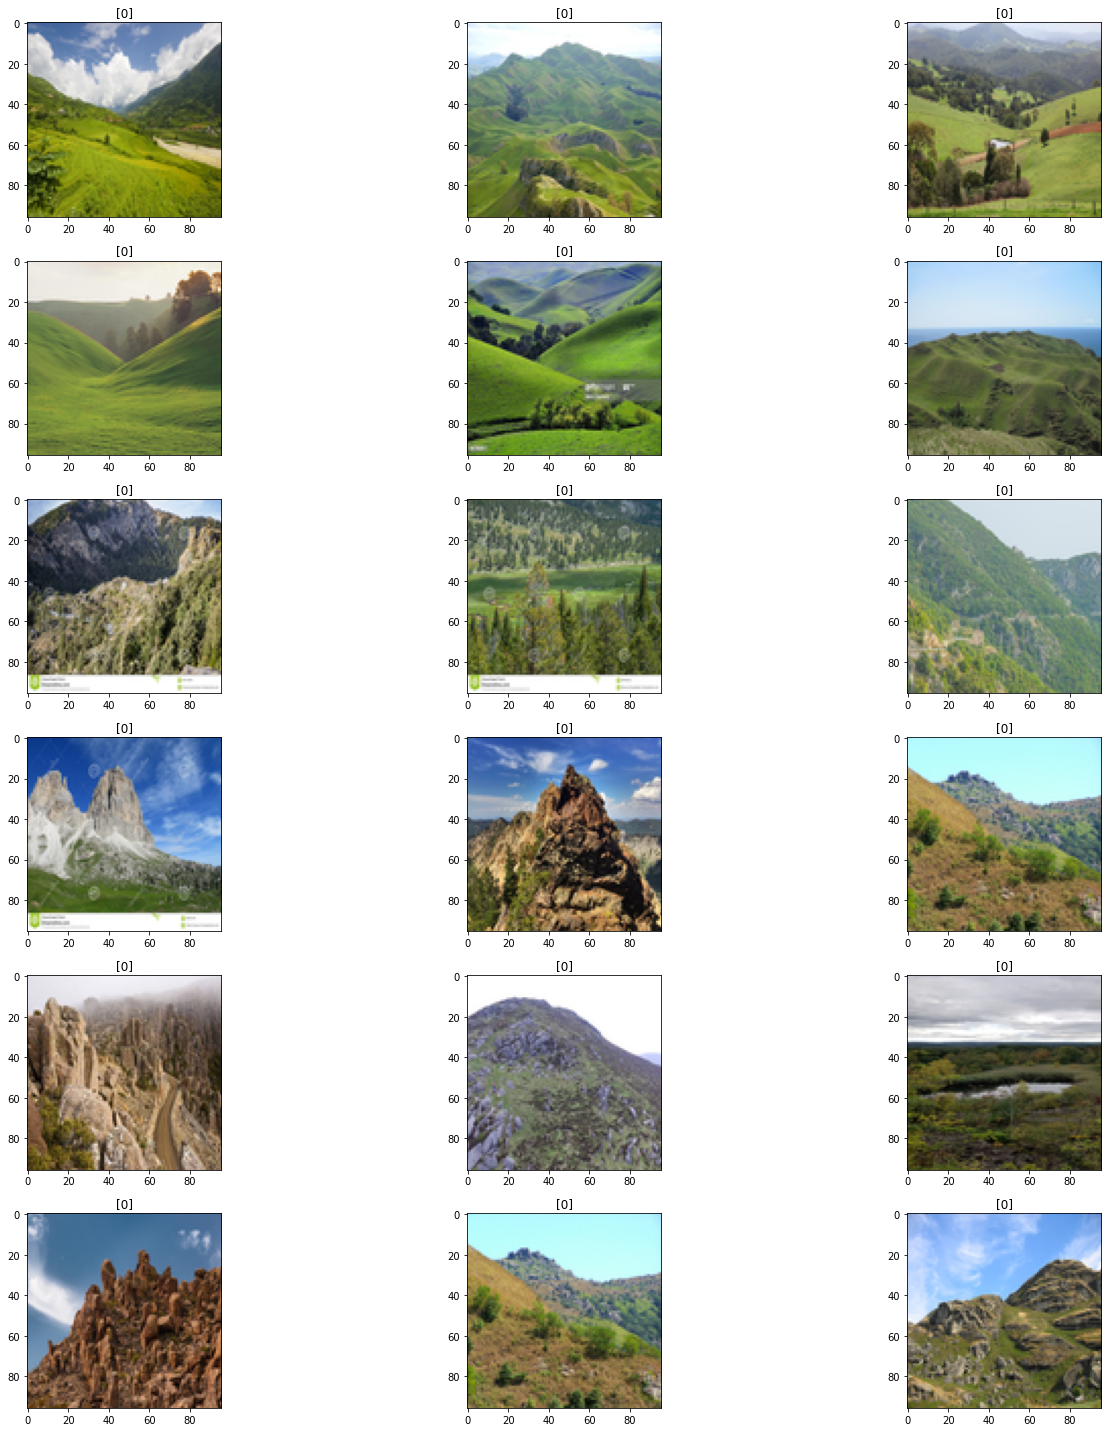

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(20,20))
l =  testdata_fire.shape[0]

#plt.figure(0)
count = 0;
for i in range(6):
    for j in range(3):
        plt.subplot2grid((6,3), (i,j))
        #ax[i,j].set_title('subplot 1')
        ax = plt.subplot2grid((6,3), (i,j))
        x = np.reshape(testdata_fire[count], (96,96,3))

        y = np.reshape(feature_ext[count], (1, 3,3,512))
        p = model1.predict_classes(y)
        

        #pred = model1.predict_classes(feature_ext[count])
        ax.set_title(p[0])
        #print("Class : ",pred)


        count = count + 1 
        img = x.astype(np.uint8)
        fig.tight_layout()
        pyplot.imshow(img)
plt.show()

### Validation Accuracy

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
#Predictions
#y_pred = model1.predict(val_data).argmax(-1)
y_pred = model1.predict_classes(val_data_extracted)
y_pred= y_pred.reshape(val_data.shape[0],1)

#Metrics
#loss, acc = seqmodel.evaluate(val_data,  val_label, verbose=1)
#print('\model, accuracy: {:5.2f}%'.format(100*acc))

print("Precision: "+ str(precision_score(val_label, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(val_label, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(val_label, y_pred)))

Precision: 0.9836499532855807
Recall: 0.9831730769230769
Accuracy: 0.9831730769230769


### Test dataset (common) Evaluation Metrics 

In [ ]:
#test_datapath = '/content/drive/My Drive/projects/test'
# Path for data from Google Drive

DATA_PATH = '/content/drive/My Drive/projects/Test'

# Creating numpy binary file to store preprocessed images for quicker loading
FFtest_data_bin = os.path.join(DATA_PATH,
        f'FF_data.npy')
NoFtest_data_bin = os.path.join(DATA_PATH,
        f'NoF_data.npy')

print(f"Looking for file: {FFtest_data_bin}")

if not os.path.isfile(FFtest_data_bin):
  start = time.time()
  print("Loading FF images...")

  FF_training_data = []
  FF_path = os.path.join(DATA_PATH,'fire')
  for filename in tqdm(os.listdir(FF_path)):
      path = os.path.join(FF_path,filename)
      image = Image.open(path).resize((image_size_sq,
            image_size_sq),Image.ANTIALIAS)
      FF_training_data.append(np.asarray(image))

  x = FF_training_data[1:]
  y=[]
  print(len(x))
  #t = np.reshape(x, (-1,96,96,3))
  for i in x:
    #print(i.shape)
    if i.shape != (96,96,3):
      print(False)
    else:
      y.append(i)

  print(len(y))

  
  FF_training_data = np.reshape(y,(-1,image_size_sq,
            image_size_sq,no_channels))
  FF_training_data = FF_training_data.astype(np.float32)
  #FF_training_data = FF_training_data / 127.5 - 1.

  print("Saving training image binary...")
  np.save(FFtest_data_bin,FF_training_data)
  elapsed = time.time()-start

else:
  FF_training_data = np.load(FFtest_data_bin)
  print("Loaded FF previously saved...")

# No fire data

if not os.path.isfile(NoFtest_data_bin):
  start = time.time()
  print("Loading NoF images...")

  NoFF_training_data = []
  FF_path = os.path.join(DATA_PATH,'nofire')
  for filename in tqdm(os.listdir(FF_path)):
      path = os.path.join(FF_path,filename)
      image = Image.open(path).resize((image_size_sq,
            image_size_sq),Image.ANTIALIAS)
      NoFF_training_data.append(np.asarray(image))
  
  
  x = NoFF_training_data[1:]
  y=[]
  print(len(x))
  #t = np.reshape(x, (-1,96,96,3))
  for i in x:
    #print(i.shape)
    if i.shape != (96,96,3):
      print(False)
    else:
      y.append(i)

  print(len(y))
  
  
  NoFF_training_data = np.reshape(y,(-1,image_size_sq,
            image_size_sq,no_channels))
  NoFF_training_data = NoFF_training_data.astype(np.float32)
  #NoFF_training_data = NoFF_training_data / 127.5 - 1.

  print("Saving training image binary...")
  np.save(NoFtest_data_bin,NoFF_training_data)
  elapsed = time.time()-start

else:
  NoFF_training_data = np.load(NoFtest_data_bin)
  print("Loaded NoFF previously saved...")


FFtest = FF_training_data
NoFTest = NoFF_training_data
#Checking size of both classes
FFtest_size = FFtest.shape
print("Size of FF data:", FFtest_size[0])
NoF_size = NoFTest.shape
print("Size of NoFF data:", NoF_size[0])

FFtest_Label = np.ones((FFtest_size[0], 1), dtype=int)
NoFtest_Label = np.zeros((NoF_size[0], 1), dtype=int)
print( FFtest_Label.shape[0], NoFtest_Label.shape[0])

Looking for file: /content/drive/My Drive/projects/Test/FF_data.npy
Loaded FF previously saved...
Loaded NoFF previously saved...
Size of FF data: 35
Size of NoFF data: 35
35 35


In [ ]:
test_data = np.concatenate((FF_training_data, NoFF_training_data), axis =0)
test_label = np.concatenate((FFtest_Label, NoFtest_Label), axis =0)
test_label_len = test_label.shape[0]


In [ ]:
BS = 1
test_gen = train_datagen.flow(x = test_data, y=test_label, batch_size=BS, shuffle=False)
feature_ext = model.predict_generator(test_gen, test_label_len // BS )
np.save(feature_ext_val_path, feature_ext)
print("Saved test features")

Saved test features


In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
#Predictions
#y_pred = model1.predict(val_data).argmax(-1)
y_pred = model1.predict_classes(feature_ext)
y_pred= y_pred.reshape(test_label.shape[0],1)

#Metrics
#loss, acc = seqmodel.evaluate(val_data,  val_label, verbose=1)
#print('\model, accuracy: {:5.2f}%'.format(100*acc))

print("Precision: "+ str(precision_score(test_label, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(test_label, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(test_label, y_pred)))

Precision: 0.9003267973856209
Recall: 0.9
Accuracy: 0.9


## 3. Transfer Learning with fine tuned VGG16 model

In [ ]:
model1.save_weights("top_model_weights_path.h5")

In [ ]:
modelnew = applications.VGG16(weights='imagenet', include_top=False, input_shape=(96,96,3))
#model = applications.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')
modelnew.summary()

Model loaded.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128

In [ ]:
#wholemodel = applications.VGG16(weights='imagenet')
#plot_model( wholemodel, show_shapes=True)


In [ ]:
top_model = Sequential()
top_model.add(Flatten(input_shape=(3,3,512)))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))
top_model.summary()
#top_model.load_weights("top_model_weights_path.h5")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 1,180,161
Trainable params: 1,180,161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
top_model.load_weights("top_model_weights_path.h5")

In [ ]:
seqmodel = Sequential()
for layer in modelnew.layers:
  seqmodel.add(layer)

In [ ]:
seqmodel.add(top_model)

In [ ]:
seqmodel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 24, 24, 256)      

In [ ]:
for layer in seqmodel.layers[:25]:
    layer.trainable = False

In [ ]:
seqmodel.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [ ]:
train_datagen = ImageDataGenerator(
              rotation_range=10,
              width_shift_range=0.2,
              height_shift_range=0.2,
              rescale=1./255,
              #shear_range=0.2,
              zoom_range=0.2,
              horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_gen = train_datagen.flow(x = train_data, y=train_label, batch_size=BS)
validation_gen = test_datagen.flow(x = val_data, y= val_label, batch_size=BS)

In [ ]:
Ep = 10
hist = seqmodel.fit_generator(
        train_gen, steps_per_epoch= train_data_length // BS, 
        epochs= Ep, verbose=1, validation_data=validation_gen,
        validation_steps= val_data_length // BS )

Epoch 1/10
1664/1664 [==============================] - 225s 135ms/step - loss: 0.2732 - accuracy: 0.9724 - val_loss: 0.2486 - val_accuracy: 0.9832
Epoch 2/10
1664/1664 [==============================] - 226s 136ms/step - loss: 0.2565 - accuracy: 0.9736 - val_loss: 0.2486 - val_accuracy: 0.9832
Epoch 3/10
1664/1664 [==============================] - 225s 135ms/step - loss: 0.3668 - accuracy: 0.9645 - val_loss: 0.2486 - val_accuracy: 0.9832
Epoch 4/10
1664/1664 [==============================] - 226s 136ms/step - loss: 0.3419 - accuracy: 0.9609 - val_loss: 0.2486 - val_accuracy: 0.9832
Epoch 5/10
1664/1664 [==============================] - 225s 136ms/step - loss: 0.3352 - accuracy: 0.9724 - val_loss: 0.2486 - val_accuracy: 0.9832
Epoch 6/10
1664/1664 [==============================] - 227s 137ms/step - loss: 0.2625 - accuracy: 0.9748 - val_loss: 0.2486 - val_accuracy: 0.9832
Epoch 7/10
1664/1664 [==============================] - 244s 147ms/step - loss: 0.3121 - accuracy: 0.9651 - val_

In [ ]:
seqmodel.save_weights("RF-SF_FineTunedVGG.h5")

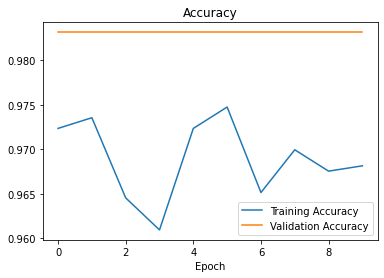

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
#plt.plot(hist.history['loss'])
plt.title("Accuracy")
#plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training Accuracy","Validation Accuracy","loss"])
plt.show()

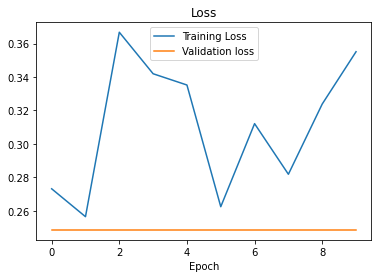

In [ ]:

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Loss")
#plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training Loss","Validation loss"])
plt.show()

## TEST

### Test dataset (common) Evaluation Metrics 

In [ ]:
#test_datapath = '/content/drive/My Drive/projects/test'
# Path for data from Google Drive

DATA_PATH = '/content/drive/My Drive/projects/Test'

# Creating numpy binary file to store preprocessed images for quicker loading
FFtest_data_bin = os.path.join(DATA_PATH,
        f'FF_data.npy')
NoFtest_data_bin = os.path.join(DATA_PATH,
        f'NoF_data.npy')

print(f"Looking for file: {FFtest_data_bin}")

if not os.path.isfile(FFtest_data_bin):
  start = time.time()
  print("Loading FF images...")

  FF_training_data = []
  FF_path = os.path.join(DATA_PATH,'fire')
  for filename in tqdm(os.listdir(FF_path)):
      path = os.path.join(FF_path,filename)
      image = Image.open(path).resize((image_size_sq,
            image_size_sq),Image.ANTIALIAS)
      FF_training_data.append(np.asarray(image))

  x = FF_training_data[1:]
  y=[]
  print(len(x))
  #t = np.reshape(x, (-1,96,96,3))
  for i in x:
    #print(i.shape)
    if i.shape != (96,96,3):
      print(False)
    else:
      y.append(i)

  print(len(y))

  
  FF_training_data = np.reshape(y,(-1,image_size_sq,
            image_size_sq,no_channels))
  FF_training_data = FF_training_data.astype(np.float32)
  #FF_training_data = FF_training_data / 127.5 - 1.

  print("Saving training image binary...")
  np.save(FFtest_data_bin,FF_training_data)
  elapsed = time.time()-start

else:
  FF_training_data = np.load(FFtest_data_bin)
  print("Loaded FF previously saved...")

# No fire data

if not os.path.isfile(NoFtest_data_bin):
  start = time.time()
  print("Loading NoF images...")

  NoFF_training_data = []
  FF_path = os.path.join(DATA_PATH,'nofire')
  for filename in tqdm(os.listdir(FF_path)):
      path = os.path.join(FF_path,filename)
      image = Image.open(path).resize((image_size_sq,
            image_size_sq),Image.ANTIALIAS)
      NoFF_training_data.append(np.asarray(image))
  
  
  x = NoFF_training_data[1:]
  y=[]
  print(len(x))
  #t = np.reshape(x, (-1,96,96,3))
  for i in x:
    #print(i.shape)
    if i.shape != (96,96,3):
      print(False)
    else:
      y.append(i)

  print(len(y))
  
  
  NoFF_training_data = np.reshape(y,(-1,image_size_sq,
            image_size_sq,no_channels))
  NoFF_training_data = NoFF_training_data.astype(np.float32)
  #NoFF_training_data = NoFF_training_data / 127.5 - 1.

  print("Saving training image binary...")
  np.save(NoFtest_data_bin,NoFF_training_data)
  elapsed = time.time()-start

else:
  NoFF_training_data = np.load(NoFtest_data_bin)
  print("Loaded NoFF previously saved...")


FFtest = FF_training_data
NoFTest = NoFF_training_data
#Checking size of both classes
FFtest_size = FFtest.shape
print("Size of FF data:", FFtest_size[0])
NoF_size = NoFTest.shape
print("Size of NoFF data:", NoF_size[0])

FFtest_Label = np.ones((FFtest_size[0], 1), dtype=int)
NoFtest_Label = np.zeros((NoF_size[0], 1), dtype=int)
print( FFtest_Label.shape[0], NoFtest_Label.shape[0])

Looking for file: /content/drive/My Drive/projects/Test/FF_data.npy
Loaded FF previously saved...
Loaded NoFF previously saved...
Size of FF data: 35
Size of NoFF data: 35
35 35


In [ ]:
test_data = np.concatenate((FF_training_data, NoFF_training_data), axis =0)
test_label = np.concatenate((FFtest_Label, NoFtest_Label), axis =0)
test_label_len = test_label.shape[0]


### Test Evaluation Metrics for 2. VGG16 model

In [ ]:
BS = 1
test_gen = train_datagen.flow(x = test_data, y=test_label, batch_size=BS, shuffle=False)
feature_ext = model.predict_generator(test_gen, test_label_len // BS )
np.save(feature_ext_val_path, feature_ext)
print("Saved test features")

Saved test features


In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
#Predictions
#y_pred = model1.predict(val_data).argmax(-1)
y_pred = seqmodel.predict_classes(test_data)
y_pred= y_pred.reshape(test_label.shape[0],1)

#Metrics
#loss, acc = seqmodel.evaluate(val_data,  val_label, verbose=1)
#print('\model, accuracy: {:5.2f}%'.format(100*acc))

print("Precision: "+ str(precision_score(test_label, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(test_label, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(test_label, y_pred)))

Precision: 0.7777777777777778
Recall: 0.6
Accuracy: 0.6


### Validation Accuracy for basic CNN

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
#Predictions
#y_pred = model1.predict(val_data).argmax(-1)
y_pred = classifier.predict_classes(test_data)
y_pred= y_pred.reshape(test_data.shape[0],1)

#Metrics
#loss, acc = seqmodel.evaluate(val_data,  val_label, verbose=1)
#print('\model, accuracy: {:5.2f}%'.format(100*acc))

print("Precision: "+ str(precision_score(test_label, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(test_label, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(test_label, y_pred)))

Precision: 0.6615384615384615
Recall: 0.5428571428571428
Accuracy: 0.5428571428571428
